# Importing necessary packages

In [1]:
import datetime as dt
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.options.mode.chained_assignment = None
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

# Read data

In [2]:
df_final = pd.read_csv("../data/df_final_monthly.csv")


In [3]:
df_final = df_final.drop(["Unnamed: 0"], axis=1)
df_final = df_final.drop(
    ["date", "amount", "positive_transactions", "negative_transactions"], axis=1
)

In [4]:
df_final

,balance_per_day,sum_outgoing_next_30_days,sum_income_next_30_days,negative_transaction_last_1_month,positive_transaction_last_1_month,negative_transaction_last_2_month,positive_transaction_last_2_month,negative_transaction_last_3_month,positive_transaction_last_3_month,negative_transaction_last_4_month,positive_transaction_last_4_month,negative_transaction_last_5_month,positive_transaction_last_5_month,negative_transaction_last_6_month,positive_transaction_last_6_month
0,18.36,-3225.94,3215.50,-1585.20,1587.00,-1000.00,1000.00,-1070.29,1066.00,-3562.99,1828.00,-102.00,1841.00,-5037.00,1952.00
1,7.92,-5186.10,5185.80,-3225.94,3215.50,-1585.20,1587.00,-1000.00,1000.00,-1070.29,1066.00,-3562.99,1828.00,-102.00,1841.00
2,4.41,-835.00,831.00,-7165.81,7165.00,-556.54,205.00,-9818.04,10252.33,-4768.09,4770.40,-5929.04,5896.49,-747.32,770.00
3,1962.71,-11866.82,14875.79,-15941.46,16689.22,-12972.15,12515.82,-9490.21,8749.92,-15066.06,9488.18,-11310.98,10098.09,-4196.96,12120.28
4,3833.87,-11306.21,8283.15,-11866.82,14875.79,-15941.46,16689.22,-12972.15,12515.82,-9490.21,8749.92,-15066.06,9488.18,-11310.98,10098.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6388,1737.22,-6727.94,6617.65,-8465.18,8279.85,-3363.25,4500.00,-852.69,1005.72,0.00,0.00,0.00,0.00,0.00,0.00
6389,2119.95,-5271.70,7420.93,-6727.94,6617.65,-8465.18,8279.85,-3363.25,4500.00,-852.69,1005.72,0.00,0.00,0.00,0.00
6390,3545.20,-6758.57,6358.83,-5271.70,7420.93,-6727.94,6617.65,-8465.18,8279.85,-3363.25,4500.00,-852.69,1005.72,0.00,0.00
6391,2886.05,-5145.89,3000.00,-6758.57,6358.83,-5271.70,7420.93,-6727.94,6617.65,-8465.18,8279.85,-3363.25,4500.00,-852.69,1005.72


The dataset used for prediction contains for each observation the amount of balance, expenses for next month,incomes for next month, expenses for previous 1 to 6 months and incomes for previous 1 to 6 months. We chose to stop at 6 months of history because as we defined in the peoject tasks, we only requires 6 months of transactions history.

We can add more features to the data if we had more domain knowledge.

# Handle outliers

We want to handle outliers. We will handle the balance_per_day feature of the df_final dataset.

Let’s look at the graphs boxplot and histogram.

<AxesSubplot:xlabel='balance_per_day'>

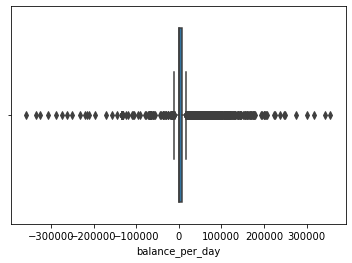

In [5]:
sns.boxplot(x=df_final["balance_per_day"])

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


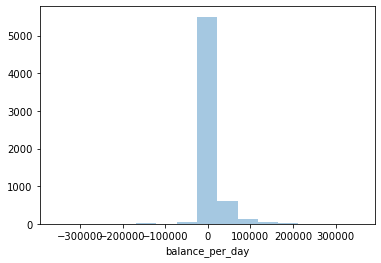

In [6]:
sns.distplot(df_final["balance_per_day"], bins=15, kde=False)
plt.show()

We can see this column has outliers (it is shown at boxplot) and it is right-skewed data(it is easily seen at histogram). For detecting outliers, we will use Tukey’s rule whiich is also known as the IQR rule. First, we will calculate the Interquartile Range of the data (IQR = Q3 — Q1). Later, we will determine our outlier boundaries with IQR. 

Our lower boundary with this calculation is Q1–1.5 * IQR, and our upper boundary with this calculation is Q3 + 1.5 * IQR. 

The data outside of the between lower and upper boundaries are outliers.

Let's view some basic statistical details of df_final like percentile, mean, std etc. and also
have our data’s Q1 (%25) and Q3 (%75) percentiles.

In [7]:
df_final.describe()

,balance_per_day,sum_outgoing_next_30_days,sum_income_next_30_days,negative_transaction_last_1_month,positive_transaction_last_1_month,negative_transaction_last_2_month,positive_transaction_last_2_month,negative_transaction_last_3_month,positive_transaction_last_3_month,negative_transaction_last_4_month,positive_transaction_last_4_month,negative_transaction_last_5_month,positive_transaction_last_5_month,negative_transaction_last_6_month,positive_transaction_last_6_month
count,6393.000000,6393.000000,6393.000000,6393.000000,6393.000000,6393.000000,6393.000000,6393.000000,6393.000000,6393.000000,6393.000000,6393.000000,6393.000000,6393.000000,6393.000000
mean,7866.266136,-4180.117901,3145.740746,-4105.124217,3104.765243,-4082.728217,3092.712403,-4084.128026,3078.861722,-3977.762636,3012.143280,-3835.330274,2954.655206,-3638.025167,2885.043133
std,30541.340873,5845.432488,4337.707318,5750.543549,4270.207444,5850.588460,4368.158982,6086.711940,4406.855805,6096.933245,4425.816826,6109.861751,4421.555745,5832.611480,4456.036038
min,-358608.600000,-75728.820000,0.000000,-75728.820000,0.000000,-79454.940000,0.000000,-113523.230000,0.000000,-113523.230000,0.000000,-150160.270000,0.000000,-150160.270000,0.000000
25%,11.990000,-5191.740000,288.400000,-5119.090000,252.000000,-5076.890000,226.300000,-5023.880000,251.340000,-4918.700000,220.520000,-4717.350000,200.000000,-4463.880000,175.000000
50%,396.960000,-2322.740000,1771.810000,-2259.950000,1750.000000,-2194.000000,1721.020000,-2160.830000,1718.920000,-2090.920000,1688.790000,-1991.350000,1644.000000,-1860.000000,1567.290000
75%,7101.540000,-736.480000,4224.390000,-708.900000,4177.180000,-682.990000,4129.580000,-675.200000,4096.950000,-641.580000,4013.600000,-580.950000,3900.000000,-501.740000,3785.070000
max,355668.930000,0.000000,61746.900000,0.000000,61746.900000,0.000000,61746.900000,0.000000,66065.920000,0.000000,74359.670000,0.000000,74359.670000,0.000000,74359.670000


The data is very spread out of the mean. Let's compute IQR. 

In [8]:
Q1 = df_final["balance_per_day"].quantile(0.25)
Q3 = df_final["balance_per_day"].quantile(0.75)
IQR = Q3 - Q1

In [9]:
lower_lim = Q1 - 1.5 * IQR
upper_lim = Q1 + 1.5 * IQR

In [10]:
print(lower_lim)
print(upper_lim)

-10622.335000000001
10646.315


Let's reach outliers and index.

In [11]:
outliers_15_low = df_final["balance_per_day"] < lower_lim
outliers_15_up = df_final["balance_per_day"] > upper_lim

In [12]:
len(df_final["balance_per_day"]) - (
    len(df_final["balance_per_day"][outliers_15_low])
    + len(df_final["balance_per_day"][outliers_15_up])
)

5016

In [13]:
outliers_15_low

0       False
1       False
2       False
3       False
4       False
        ...  
6388    False
6389    False
6390    False
6391    False
6392    False
Name: balance_per_day, Length: 6393, dtype: bool

In [14]:
df_final["balance_per_day"][(outliers_15_low | outliers_15_up)]

32      43165.85
33      42644.05
34      42664.33
35      42859.59
36      42816.61
          ...   
6372    36294.86
6373    33599.35
6374    27371.74
6375    25206.52
6376    18055.14
Name: balance_per_day, Length: 1377, dtype: float64

In [15]:
df_final = df_final[~(outliers_15_low | outliers_15_up)]

In [16]:
df_final

,balance_per_day,sum_outgoing_next_30_days,sum_income_next_30_days,negative_transaction_last_1_month,positive_transaction_last_1_month,negative_transaction_last_2_month,positive_transaction_last_2_month,negative_transaction_last_3_month,positive_transaction_last_3_month,negative_transaction_last_4_month,positive_transaction_last_4_month,negative_transaction_last_5_month,positive_transaction_last_5_month,negative_transaction_last_6_month,positive_transaction_last_6_month
0,18.36,-3225.94,3215.50,-1585.20,1587.00,-1000.00,1000.00,-1070.29,1066.00,-3562.99,1828.00,-102.00,1841.00,-5037.00,1952.00
1,7.92,-5186.10,5185.80,-3225.94,3215.50,-1585.20,1587.00,-1000.00,1000.00,-1070.29,1066.00,-3562.99,1828.00,-102.00,1841.00
2,4.41,-835.00,831.00,-7165.81,7165.00,-556.54,205.00,-9818.04,10252.33,-4768.09,4770.40,-5929.04,5896.49,-747.32,770.00
3,1962.71,-11866.82,14875.79,-15941.46,16689.22,-12972.15,12515.82,-9490.21,8749.92,-15066.06,9488.18,-11310.98,10098.09,-4196.96,12120.28
4,3833.87,-11306.21,8283.15,-11866.82,14875.79,-15941.46,16689.22,-12972.15,12515.82,-9490.21,8749.92,-15066.06,9488.18,-11310.98,10098.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6388,1737.22,-6727.94,6617.65,-8465.18,8279.85,-3363.25,4500.00,-852.69,1005.72,0.00,0.00,0.00,0.00,0.00,0.00
6389,2119.95,-5271.70,7420.93,-6727.94,6617.65,-8465.18,8279.85,-3363.25,4500.00,-852.69,1005.72,0.00,0.00,0.00,0.00
6390,3545.20,-6758.57,6358.83,-5271.70,7420.93,-6727.94,6617.65,-8465.18,8279.85,-3363.25,4500.00,-852.69,1005.72,0.00,0.00
6391,2886.05,-5145.89,3000.00,-6758.57,6358.83,-5271.70,7420.93,-6727.94,6617.65,-8465.18,8279.85,-3363.25,4500.00,-852.69,1005.72


We removed the outliers and our data rows drop from 6393 to 5016

In [17]:
df_final.describe()

,balance_per_day,sum_outgoing_next_30_days,sum_income_next_30_days,negative_transaction_last_1_month,positive_transaction_last_1_month,negative_transaction_last_2_month,positive_transaction_last_2_month,negative_transaction_last_3_month,positive_transaction_last_3_month,negative_transaction_last_4_month,positive_transaction_last_4_month,negative_transaction_last_5_month,positive_transaction_last_5_month,negative_transaction_last_6_month,positive_transaction_last_6_month
count,5016.000000,5016.000000,5016.000000,5016.000000,5016.000000,5016.000000,5016.000000,5016.000000,5016.000000,5016.000000,5016.000000,5016.000000,5016.000000,5016.000000,5016.000000
mean,1099.176742,-2857.601782,2757.831400,-2896.396206,2667.156336,-2904.413415,2665.464450,-2940.419151,2638.811204,-2894.344613,2601.811876,-2815.626384,2547.042456,-2714.384264,2491.341798
std,2771.084053,3460.680129,3537.019124,3595.053212,3315.137118,3706.659167,3439.884103,3910.954860,3455.668629,3880.635303,3464.456104,3867.963158,3386.571073,3771.924396,3429.266215
min,-10407.230000,-40566.690000,0.000000,-39818.010000,0.000000,-39818.010000,0.000000,-51803.190000,0.000000,-51803.190000,0.000000,-51803.190000,0.000000,-51803.190000,0.000000
25%,5.895000,-3940.587500,314.900000,-3962.410000,288.542500,-3918.057500,252.000000,-3896.410000,259.967500,-3842.490000,249.280000,-3708.052500,234.742500,-3616.382500,206.530000
50%,158.515000,-1795.880000,1688.065000,-1813.410000,1642.330000,-1754.900000,1600.210000,-1738.150000,1593.445000,-1701.060000,1570.955000,-1636.185000,1531.940000,-1550.975000,1500.000000
75%,1217.820000,-510.000000,3784.277500,-492.592500,3707.710000,-491.007500,3684.695000,-482.347500,3648.432500,-463.202500,3573.580000,-418.902500,3500.000000,-371.627500,3443.115000
max,10622.520000,0.000000,51709.920000,0.000000,31348.900000,0.000000,36512.690000,0.000000,50873.930000,0.000000,52565.860000,0.000000,52565.860000,0.000000,66065.920000


# Metrics definition

We are dealing with a regression problem. We chose MAE and MAPE as metrics. 

Indeed, MAE is a natural measure of average error magnitude and it is more robust
against outliers in our data compared to RMSE for example where error terms with larger magnitudes 
will be more pronounced, making them even larger. 

MAPE is the percentage equivalent of MAE. Just as MAE is the average magnitude of error produced by the model, the MAPE is how far the model’s predictions are off from their corresponding outputs on average. 


In [18]:
def mae(y_pred, y_true):
    """
    Returns mean absolute error 
    """

    return np.mean(np.abs(y_pred - y_true))

In [19]:
def mape(y_pred, y_true):
    """
    Returns mean absolute percentage error  
    """

    return (
        np.mean(
            np.abs((y_true - y_pred) / y_true)[
                np.isfinite(np.abs((y_true - y_pred) / y_true))
            ]
        )
        * 100
    )

# Split data to train and test sets

In this part, we split the data into independant and dependant variables. The dependant variable (or target variable)
is the column "sum_outgoing_next_30_days" because that's exactly what we want to predict. The independant variables are all the remaining columns.

We use a StandardScaler to rescale teh features.

We also split the date into train and test sets. We trained the data on train set and predict on test sets.
We chose to train on 80% of the data and test on the remaining 20%.

In [20]:
y = df_final["sum_outgoing_next_30_days"]
X = df_final.drop(["sum_outgoing_next_30_days", "sum_income_next_30_days"], axis=1)
features = X.columns
scaler = StandardScaler()  

X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

In [21]:
X_train = X_train.astype("float32")
y_train = y_train.astype("float32")
X_test = X_test.astype("float32")
y_test = y_test.astype("float32")

# Statistical analysis & Correlation

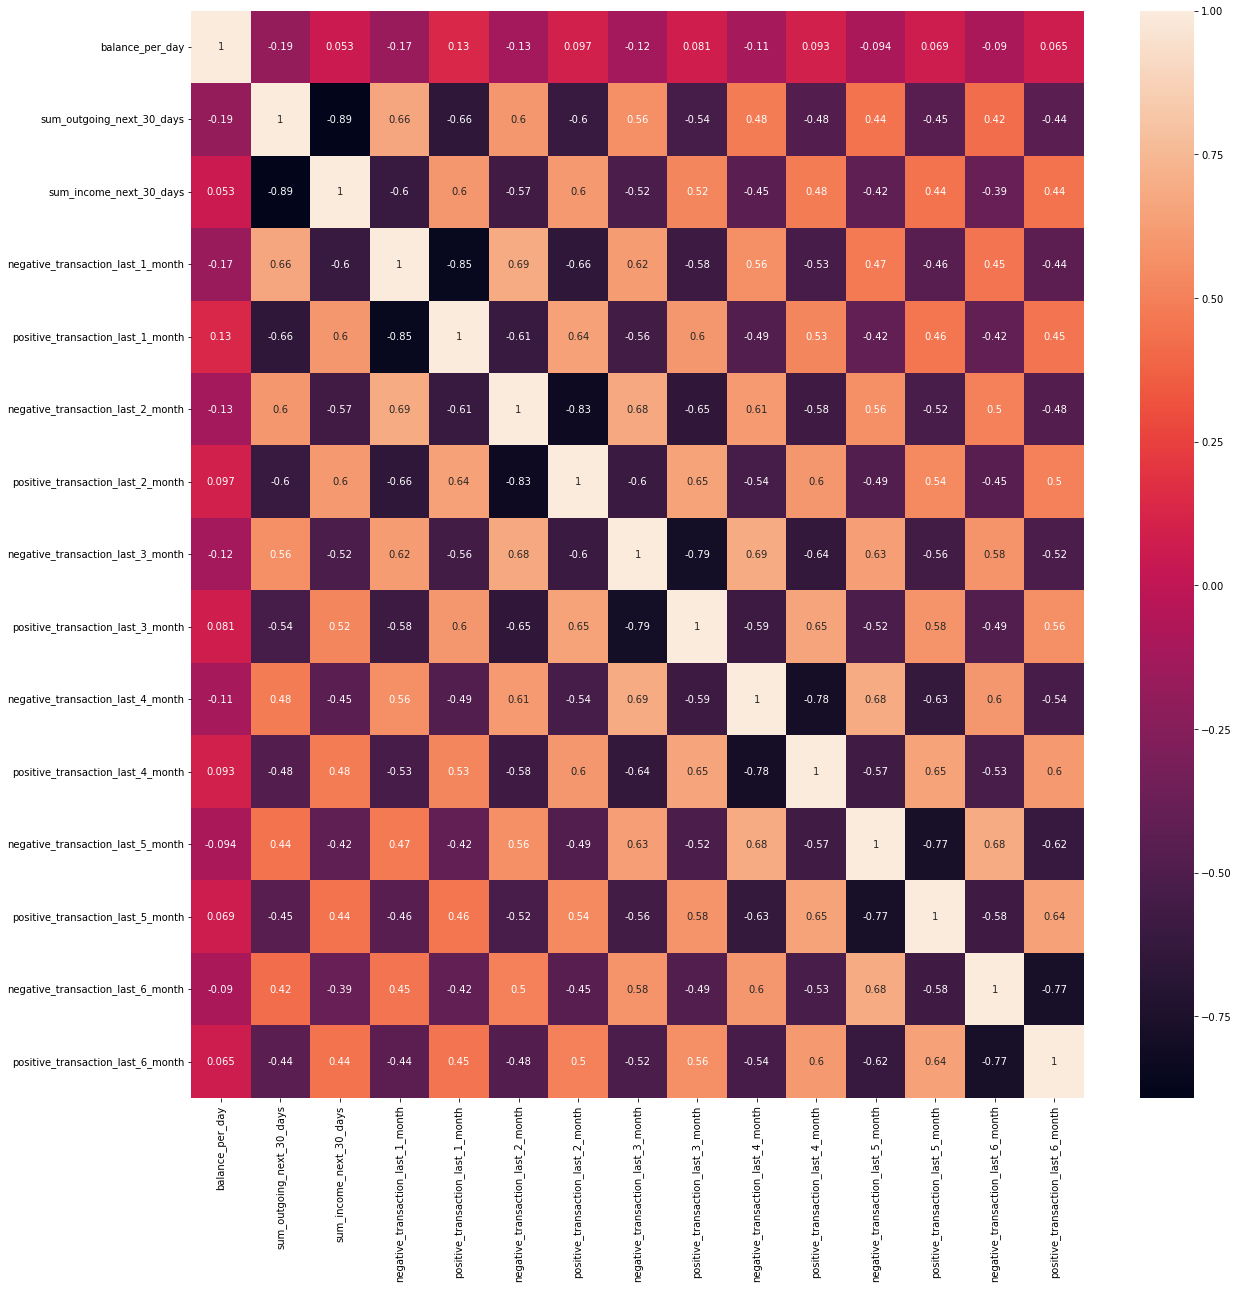

In [22]:
corrMatrix = df_final.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corrMatrix, annot=True)
plt.show()

Now, we will create a correlation matrix to see the correlation coefficients between different variables.

The correlation matrix shows that the target variable is positively correlated to the negative transactions of last month. Which means that if the expenses in a month increase, the expensescin the next month increase along with it. The target variable is correlated to the positive transactions of last month with the same strength as last variable we discussed, but negatively. 

The strength of correlations between sum_outgoing_next_30_days and the history of incomes and expenses of last months
decreases as we go far in history. 

# Modeling

For the modeling part, we chose to fit the data first to a baseline model which is a 
simple **linnear regression**. Then, we tried to make more complex models, namely **Random Forest regressor**, **XGBOOST regressor** without and with **PCA**, regressor based on clusters of samples based on the balance median, Random Forest with GridSearch and neural network to get better results. 

Let's see if we can achieve a better score than the baseline. 

## Linear Regression

In [23]:
lr = LinearRegression().fit(X_train, y_train)

In [24]:
print("MAE On Training Set for LR")
mae(lr.predict(X_train), y_train)

MAE On Training Set for LR


1449.666259765625

In [25]:
print("MAE On Test Set for LR")
mae(lr.predict(X_test), y_test)

MAE On Test Set for LR


1538.3406982421875

In [26]:
print("MAPE On Test Set for LR")
mape(lr.predict(X_test), y_test)

MAPE On Test Set for LR


1477.8242111206055

We can notice that the difference between MAE on training and test sets is not big, so we don't see a clear overfitting with this **Linear Regression model**, this model is suffering from bias more than overfitting. By looking into the **Mean Absolute Percentage Error**, the error is very high.

## RandomForest Regressor

### Importance Features

In [27]:
## Features importance using random forest
model_rdf = RandomForestRegressor(n_estimators=300)
model_rdf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300)

Text(0.5, 1.0, 'RandomForest Importance Features')

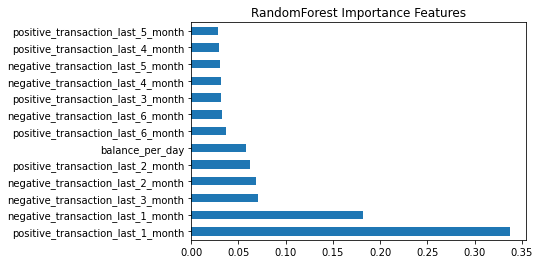

In [28]:
feat_importances = pd.Series(model_rdf.feature_importances_, index=features)
feat_importances.nlargest(15).plot(kind="barh")
plt.title("RandomForest Importance Features")

 From the Importance Features plot above, we can notice that the most important features to predict the coming 30 days outgoing transactions are the positive and negative moonthly transactions during the latest months, which could be explained by the fact that the  coming 30 days outgoing transactions fo a given id depend on the latest incoming and outgoings trasactions in the latest months.

### Fit and Evaluate a Random Forest 

In [29]:
print("MAE On Training Set for RDF")
mae(model_rdf.predict(X_train), y_train)

MAE On Training Set for RDF


555.0263897451895

In [30]:
print("MAE On Test Set for RDF")
mae(model_rdf.predict(X_test), y_test)

MAE On Test Set for RDF


1523.4894644798194

In [31]:
print("MAPE On Test Set for RDF")
mape(model_rdf.predict(X_test), y_test)

MAPE On Test Set for RDF


1137.6047212522349

By fitting this random forest model, we can see that the  MAE training error is far from the test error, and the MAE test error is still near to the test error of the base linear regression model. But the MAPE is better compared to linear regression.
 To improve this model, we can tune Hyperparameters using GridSearch or try to use Principal Components as features. 

## XGBOOST Regressor

### Importance Features

In [32]:
## Features importance using gradient boosting
model_xgb = xgb.XGBRegressor(n_estimators=300)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

Text(0.5, 1.0, 'XGB Importance Features')

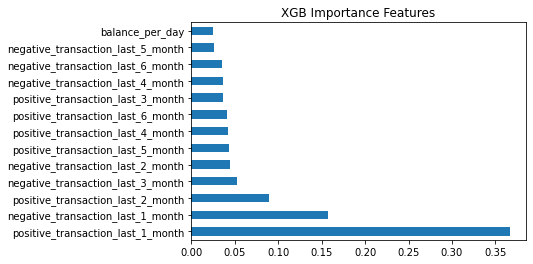

In [33]:
feat_importances = pd.Series(model_xgb.feature_importances_, index=features)
feat_importances.nlargest(15).plot(kind="barh")
plt.title("XGB Importance Features")

We fit the gradient boosting regressor on our data, because this model is very known with its capcity to reduce the bias. We can see as before, that the most important features to predict the coming 30 days outgoings, are the latest positive and negative monthly transactions.

### Fit and Evaluate an XGboost 

In [34]:
print("MAE On Training Set for XGB")
mae(model_xgb.predict(X_train), y_train)

MAE On Training Set for XGB


75.35559844970703

In [35]:
print("MAE On Test Set for XGB")
mae(model_xgb.predict(X_test), y_test)

MAE On Test Set for XGB


1644.3779296875

In [36]:
print("MAPE On Test Set for XGB")
mape(model_xgb.predict(X_test), y_test)

MAPE On Test Set for XGB


1063.127613067627

By fitting this Xgboost model, we can see that MAE test error still near from the test error from the base linear regression model. To improve this model, we can tune Hyperparameters using GridSearch or try to use Principal Components as features. The MAPE for this XGBOOSt model is better than the above models

## Principal Components Analysis

In this part, we will apply a PCA on the data before training Random Forest and XGBOOST on it. **Principal Components Analysis** allows catching colinearities between features, and using these principal componenents will allow to reduce bias due to these colinearities. In our problem, the colineraties may come from the the fact the relationship between balance, monthly positive and negative transactions is linear.

Text(0.5, 1.0, 'Cumulative explained variance ratio')

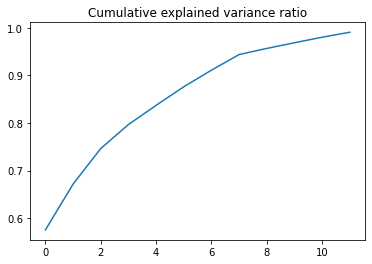

In [37]:
### PCA

nb_pc = 12  
pca = PCA(n_components=nb_pc)
principalComponents = pca.fit_transform(X)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Cumulative explained variance ratio")

W can see in the figure above, the cumulative sum of the **eigenvalues** that are corrpsonding to the **cumulative explained variance**, we can see that using only the most important **6 components** will allow to explain 90% of the variance. For this reason, we will use these 6 components as features.

In [38]:
pca = PCA(n_components=6)
principalComponentsTrain = pca.fit_transform(X_train)
principalComponentsTest = pca.transform(X_test)

### Linear Regression using PCA

In [39]:
lr_pca = LinearRegression().fit(principalComponentsTrain, y_train)

In [40]:
print("MAE on test set using LR")
mae(lr_pca.predict(principalComponentsTest), y_test)

MAE on test set using LR


1522.677001953125

In [41]:
print("MAPE on test set using LR")
mape(lr_pca.predict(principalComponentsTest), y_test)

MAPE on test set using LR


1430.0138473510742

### RandomForest with PCA

In [42]:

model_rdf_pca = RandomForestRegressor(n_estimators=300)
model_rdf_pca.fit(principalComponentsTrain, y_train)
print("MAE on test set using RDF")
mae(model_rdf_pca.predict(principalComponentsTest), y_test)

MAE on test set using RDF


1569.7001546675567

In [43]:
print("MAPE on test set using RDF")
mape(model_rdf_pca.predict(principalComponentsTest), y_test)

MAPE on test set using RDF


1246.0303700458526

### XGBOOST with PCA

In [44]:

model_xgb_pca = xgb.XGBRegressor(n_estimators=300)
model_xgb_pca.fit(principalComponentsTrain, y_train)
print("MAE on test set using XGB")
mae(model_xgb_pca.predict(principalComponentsTest), y_test)

MAE on test set using XGB


1679.1639404296875

In [45]:
print("MAPE on test set using XGB")
mape(model_xgb_pca.predict(principalComponentsTest), y_test)

MAPE on test set using XGB


1309.6441268920898

Using Principal Components does not improve the test MAE, so we will not use PCA on our final model in order to keep the explanability of the features. From a **Buisness perspective**, explanability of the models is very important, so we prefer keep original features that are easily explained.

## Train regressors based on balance_per_day >= median(balance_per_day)

In this section, we have decided to split the dataset into two balanced dataset based on the median of the most updated balance, because we assume that the negative transactions of a given customer will depend on its balance and we need to fit many models based and take into consideration the homogenity of the accounts' groups. It will be better to train two models for accounts with a low account balance and a model for accounts with high balance. Unfortunately we have around 5000 rows, in our dataset, so we cannot split this dataset to more than 2 accounts' group. We tried also **KMeans** clustering to cluster accounts based on all features, but we got **two unbalanced clusters**, for this reason, we chose the balance median as a criterion to split data into two balanced groups.

In [46]:
med_balance = np.median(df_final["balance_per_day"])


y_g = df_final[df_final["balance_per_day"] >= med_balance][
    "sum_outgoing_next_30_days"
]
X_g = df_final[df_final["balance_per_day"] >= med_balance].drop(
    ["sum_outgoing_next_30_days", "sum_income_next_30_days"], axis=1
)
#       +['positive_transaction_last_'+str(i+1)+'_month' for i in
# range(6)],axis=1)
X_g.describe()



,balance_per_day,negative_transaction_last_1_month,positive_transaction_last_1_month,negative_transaction_last_2_month,positive_transaction_last_2_month,negative_transaction_last_3_month,positive_transaction_last_3_month,negative_transaction_last_4_month,positive_transaction_last_4_month,negative_transaction_last_5_month,positive_transaction_last_5_month,negative_transaction_last_6_month,positive_transaction_last_6_month
count,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000
mean,2621.244868,-3672.790642,3335.834908,-3543.851300,3216.977049,-3480.147273,3045.073050,-3397.699490,3017.120327,-3179.506703,2816.193720,-3048.068230,2734.127500
std,2977.781666,3999.551605,3636.996509,4106.013628,3827.500817,4474.904945,3844.716602,4312.393635,3965.648479,4211.039211,3715.015802,4170.183066,3749.838366
min,158.530000,-39818.010000,0.000000,-38421.330000,0.000000,-51803.190000,0.000000,-39818.010000,0.000000,-39201.820000,0.000000,-51803.190000,0.000000
25%,446.557500,-4886.630000,909.105000,-4710.437500,731.852500,-4425.752500,611.907500,-4394.390000,500.000000,-4083.915000,420.135000,-3936.192500,359.280000
50%,1218.140000,-2560.395000,2361.660000,-2337.440000,2114.375000,-2175.290000,1980.610000,-2112.930000,1936.670000,-1920.420000,1814.210000,-1814.370000,1754.900000
75%,3691.587500,-1131.170000,4502.822500,-970.587500,4280.642500,-874.430000,4059.892500,-790.507500,4010.010000,-641.435000,3758.147500,-535.365000,3700.995000
max,10622.520000,0.000000,31348.900000,0.000000,36512.690000,0.000000,50873.930000,0.000000,52565.860000,0.000000,52565.860000,0.000000,66065.920000


In [47]:
X_g = scaler.fit_transform(X_g)

X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(
    X_g, y_g, test_size=0.2, random_state=42, shuffle=True
)

#### Linear Regression

In [48]:
lr_up_med = LinearRegression().fit(X_train_g, y_train_g)

In [49]:
print("MAE On Training Set for LR")
mae(lr_up_med.predict(X_train_g), y_train_g)

MAE On Training Set for LR


1681.8208183709392

In [50]:
print("MAE On Test Set for LR")
mae(lr_up_med.predict(X_test_g), y_test_g)

MAE On Test Set for LR


1602.502354757682

In [51]:
print("MAPE On Test Set for LR")
mape(lr_up_med.predict(X_test_g), y_test_g)

MAPE On Test Set for LR


569.1851175994572

#### RandomForest

In [52]:
model_rdf_up_med = RandomForestRegressor(n_estimators=300)
model_rdf_up_med.fit(X_train_g, y_train_g)

RandomForestRegressor(n_estimators=300)

In [53]:
print("MAE On Training Set for RDF")
mae(model_rdf_up_med.predict(X_train_g), y_train_g)

MAE On Training Set for RDF


664.6856992585731

In [54]:
print("MAE On Test Set for RDF")
mae(model_rdf_up_med.predict(X_test_g), y_test_g)

MAE On Test Set for RDF


1571.5628510914169

In [55]:
print("MAPE On Test Set for RDF")
mape(model_rdf_up_med.predict(X_test_g), y_test_g)

MAPE On Test Set for RDF


647.2863878399716

#### XGBOOST

In [56]:
model_xgb_up_med = xgb.XGBRegressor(n_estimators=300)
model_xgb_up_med.fit(X_train_g, y_train_g)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [57]:
print("MAE On Training Set for XGB")
mae(model_xgb_up_med.predict(X_train_g), y_train_g)

MAE On Training Set for XGB


29.320160785237352

In [58]:
print("MAE On Test Set for XGB")
mae(model_xgb_up_med.predict(X_test_g), y_test_g)

MAE On Test Set for XGB


1671.0675902943763

In [59]:
print("MAPE On Test Set for XGB")
mape(model_xgb_up_med.predict(X_test_g), y_test_g)

MAPE On Test Set for XGB


465.3552287039001

The MAPEs of 3 models are better from the previous models. The XGBOOST Mape is the lowest among them.

## Train regressors based on balance_per_day < median(balance_per_day)

In [60]:
med_balance = np.median(df_final["balance_per_day"])


y_s = df_final[df_final["balance_per_day"] < med_balance][
    "sum_outgoing_next_30_days"
]
X_s = df_final[df_final["balance_per_day"] < med_balance].drop(
    ["sum_outgoing_next_30_days", "sum_income_next_30_days"]
    ,axis=1)
#     + ["positive_transaction_last_" + str(i + 1) + "_month" for i in range(6)],
#     axis=1,
# )


X_s.describe()

,balance_per_day,negative_transaction_last_1_month,positive_transaction_last_1_month,negative_transaction_last_2_month,positive_transaction_last_2_month,negative_transaction_last_3_month,positive_transaction_last_3_month,negative_transaction_last_4_month,positive_transaction_last_4_month,negative_transaction_last_5_month,positive_transaction_last_5_month,negative_transaction_last_6_month,positive_transaction_last_6_month
count,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000,2508.000000
mean,-422.891384,-2120.001770,1998.477763,-2264.975530,2113.951850,-2400.691029,2232.549358,-2390.989737,2186.503425,-2451.746065,2277.891192,-2380.700299,2248.556096
std,1363.254216,2941.343224,2803.977466,3131.563351,2900.342694,3160.635604,2962.428036,3319.788301,2817.486840,3454.051403,2999.336093,3293.523457,3056.991948
min,-10407.230000,-33265.420000,0.000000,-39818.010000,0.000000,-27427.200000,0.000000,-51803.190000,0.000000,-51803.190000,0.000000,-37511.400000,0.000000
25%,-35.872500,-2910.040000,50.560000,-3062.882500,65.135000,-3369.055000,105.480000,-3241.337500,122.542500,-3358.530000,127.527500,-3224.870000,127.355000
50%,5.890000,-1140.870000,1037.000000,-1262.375000,1131.490000,-1335.225000,1238.160000,-1360.990000,1252.870000,-1372.145000,1284.185000,-1328.665000,1241.540000
75%,39.640000,-113.555000,2793.197500,-148.890000,3000.000000,-191.912500,3164.655000,-219.247500,3139.395000,-222.097500,3262.000000,-207.345000,3153.587500
max,158.500000,0.000000,20592.080000,0.000000,28675.100000,0.000000,28675.100000,0.000000,20720.200000,0.000000,28327.860000,0.000000,31348.900000


In [61]:
X_s = scaler.fit_transform(X_s)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_s, y_s, test_size=0.2, random_state=42, shuffle=True
)

### RandomForest

In [62]:
model_rdf_under_med = RandomForestRegressor(n_estimators=300)
model_rdf_under_med.fit(X_train_s, y_train_s)

RandomForestRegressor(n_estimators=300)

In [63]:
print("MAE On Training Set for RDF")
mae(model_rdf_under_med.predict(X_train_s), y_train_s)

MAE On Training Set for RDF


475.751244768498

In [64]:
print("MAE On Test Set for RDF")
mae(model_rdf_under_med.predict(X_test_s), y_test_s)

MAE On Test Set for RDF


1229.0019474041087

In [65]:
print("MAPE On Test Set for RDF")
mape(model_rdf_under_med.predict(X_test_s), y_test_s)

MAPE On Test Set for RDF


1382.5967049425087

### XGBOOST

In [66]:
model_xgb_under_med = xgb.XGBRegressor(n_estimators=300)
model_xgb_under_med.fit(X_train_s, y_train_s)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [67]:
print("MAE On Training Set for XGB")
mae(model_xgb_under_med.predict(X_train_s), y_train_s)

MAE On Training Set for XGB


11.104742856679666

In [68]:
print("MAE On Test Set for XGB")
mae(model_xgb_under_med.predict(X_test_s), y_test_s)

MAE On Test Set for XGB


1349.3472220577562

In [69]:
print("MAPE On Test Set for XGB")
mape(model_xgb_under_med.predict(X_test_s), y_test_s)

MAPE On Test Set for XGB


928.1271574901095

We can notice that for this second cluster with low balance, the erros are higher, wich is normal because accounts with low balances may have low transactions so the absolute error will be big. But overall, the MAPE still better than the models from previous approaches.

# GridSearch Hyprparameters Tuning

### Hyperparameters Tuning for RandomForest

In [70]:
rdf_gs = RandomForestRegressor().fit(X_train, y_train)

param_test = {
    "n_estimators": [50, 100, 300],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [4, 5, 6],
    "min_samples_split": [2, 3, 4],
}

gsearch = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_test, cv=5)
gsearch.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 5, 6],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 100, 300]})

In [71]:
n_estimators = gsearch.best_params_["n_estimators"]
max_features = gsearch.best_params_["max_features"]
max_depth = gsearch.best_params_["max_depth"]
min_samples_split = gsearch.best_params_["min_samples_split"]

In [72]:
print("n_estimators", n_estimators)
print("max_features", max_features)
print("max_depth", max_depth)
print("min_samples_split", min_samples_split)

n_estimators 300
max_features log2
max_depth 6
min_samples_split 3


In [73]:
rdf_gs = RandomForestRegressor(
    n_estimators=n_estimators,
    max_features=max_features,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
)
rdf_gs = rdf_gs.fit(X_train, y_train)

In [74]:
print("MAE On Training Set for RDF")
mae(rdf_gs.predict(X_train), y_train)

MAE On Training Set for RDF


1303.2012553678624

In [75]:
print("MAE On Test Set for RDF")
mae(rdf_gs.predict(X_test), y_test)

MAE On Test Set for RDF


1531.4528930613405

In [76]:
print("MAPE On Test Set for RDF %")
mape(rdf_gs.predict(X_test), y_test)

MAPE On Test Set for RDF %


1374.3683281461626

## XGBOOST GridSearch

In [77]:

param_test = {
    "learning_rate": [0.01, 0.1, 0.5],
    "n_estimators": [100, 200, 300],
    "max_depth": [4, 5, 6]
}

gsearch = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'), param_grid=param_test, cv=5)
gsearch.fit(X, y)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
       

In [78]:
n_estimators = gsearch.best_params_["n_estimators"]
learning_rate = gsearch.best_params_["learning_rate"]
max_depth = gsearch.best_params_["max_depth"]

In [79]:
print("n_estimators", n_estimators)
print("learning_rate", learning_rate)
print("max_depth", max_depth)


n_estimators 300
learning_rate 0.01
max_depth 4


In [80]:
xgb_gs = xgb.XGBRegressor(
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_depth=max_depth,
    objective='reg:squarederror'
)
xgb_gs = xgb_gs.fit(X_train, y_train)

In [81]:
print("MAE On Training Set for XGB")
mae(xgb_gs.predict(X_train), y_train)

MAE On Training Set for XGB


1282.4505615234375

In [82]:
print("MAE On Test Set for XGB")
mae(xgb_gs.predict(X_test), y_test)

MAE On Test Set for XGB


1486.701904296875

In [83]:
print("MAPE On Test Set for XGB %")
mape(xgb_gs.predict(X_test), y_test)

MAPE On Test Set for XGB %


1139.9737358093262

We have tried many models, all of them still have a high **MAE** and **MAPE**, we will choose the model with lowest MAPE as the regressor to deploy. 

In order to improve our performance and find a better regressor, we can train a fully connected neural network or a recurrent neural network using LSTM fo example to catch the time series properties. 

In term of data processing, We can also use more data to have a larger data set, because 1200 accounts are not enough to train performant models. We can also use 30 days moving window, which will allow us have a lot more rows. Furthermore, we can use past weekly outgoings and incomes instead of monthly granularity.

Both Random Forest with Grid search and XGBOOST with grid search are giving similar results. We will save the latest XGBoost model with hyperparameters tuned using GridSearch.

## Pickle the best model

In [84]:
X = df_final.drop(["sum_outgoing_next_30_days", "sum_income_next_30_days"], axis=1)
features = X.columns
scaler = StandardScaler()  

X = scaler.fit_transform(X)

In [85]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('scaler', scaler),
    ('logreg', xgb_gs)
])

In [86]:
import pickle
pickle.dump(pipeline, open('../api/model.pkl','wb'))